<a href="https://colab.research.google.com/github/gustavotr/text-sentiment-datasets/blob/master/Spacy_TAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Faça upload do arquivo ".txt" que será analisado
O texto deve conter uma opinião/review de hotel ou restaurante

In [0]:
from google.colab import files

uploaded = files.upload()

#@markdown Arquivo de exemplo pode ser encontrado em https://github.com/gustavotr/text-sentiment-datasets/blob/master/opinioes.txt

Saving opinioes.txt to opinioes (7).txt


## Treinamento para análise de sentimento

In [0]:
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline  

In [0]:
#@markdown O dataset utilizado foi criado para esta tarefa retirando do site tripadvisor os reviews de hoteis e restaurantes de curitiba
data = pd.read_csv("https://raw.githubusercontent.com/gustavotr/text-sentiment-datasets/master/tripadvisor_reviews_curitiba.csv")
data.columns = ['review', 'rating']

#@markdown Os ratings do tripadvisor de 1 a 5 são reclassificados em Negativa (-1), Neutra (0) e Positiva (1)
di = {
    1: -1,
    2: -1,
    3: 0,
    4: 0,
    5: 1
}
data['rating'].replace(di, inplace=True)

data.head()

,review,rating
0,Se você quer comer uma massa boa e caseira o B...,1
1,Uma otima escolha no shopping Barigui Curitiba...,1
2,Minha melhor escolha para comemorar aniversári...,1
3,"No dia 15/03/19, estivemos no Barolo do Shoppi...",-1
4,"Fui ao Barolo dia 18/4 , comemorar meu anivers...",-1


### Separa o texto entre dados de treinamento e dados para validação

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.33, random_state=42)

### Plota a quantidade de cada categoria que será usada no treinamento

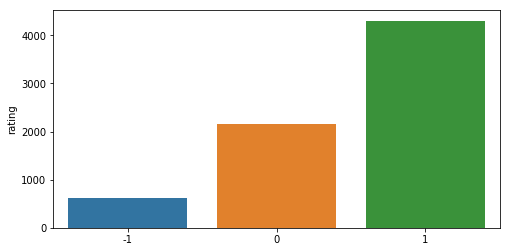

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(8,4))
sns.barplot(x = train['rating'].unique(), y=train['rating'].value_counts())
plt.show()

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
#from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
!python -m spacy download pt_core_news_sm
import string
import re
import spacy
spacy.load('pt_core_news_sm')
from spacy.lang.pt import Portuguese
parser = Portuguese()


    Linking successful
    /usr/local/lib/python3.6/dist-packages/pt_core_news_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/pt_core_news_sm

    You can now load the model via spacy.load('pt_core_news_sm')



### Cria as funções para tratar o texto

In [0]:
STOPLIST = spacy.lang.pt.stop_words.STOP_WORDS
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

class CleanTextTransformer(TransformerMixin):

   def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]

   def fit(self, X, y=None, **fit_params):
        return self

def get_params(self, deep=True):
        return {}
#@markdown Remove caracteres de quebra e retorno de linha e converte texto para letras minúsculas
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

#@markdown Remove stop words e símbolos do texto e separa as palavras como tokens
def tokenizeText(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens
  

### Realiza o trainamento

In [0]:
#@markdown Mostra as melhores palavras para determinar a categoria de um texto
def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)

vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,2))
#classificador usado
clf = LogisticRegression()

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])

# data
train1 = train['review'].tolist()
labelsTrain1 = train['rating'].tolist()

test1 = test['review'].tolist()
labelsTest1 = test['rating'].tolist()
# train
pipe.fit(train1, labelsTrain1)

# test
preds = pipe.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print("Top 10 features used to predict: ")

printNMostInformative(vectorizer, clf, 10)
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
transform = pipe.fit_transform(train1, labelsTrain1)

vocab = vectorizer.get_feature_names()
for i in range(len(train1)):
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy: 0.751506456241033
Top 10 features used to predict: 
Class 1 best: 
(-1.7153831761184826, 'excelente')
(-1.3292803028532703, 'ótimo')
(-1.288424703965177, 'delicioso')
(-1.122370684445232, 'agradável')
(-0.9870222393321083, 'saboroso')
(-0.9771604776894136, 'maravilhoso')
(-0.8170212824915254, 'confortável')
(-0.7965518008651998, 'perfazer')
(-0.6975598407919021, 'gostoso')
(-0.6926058034911632, 'limpar')
Class 2 best: 
(2.2216879093849506, 'mau')
(1.4663170555299796, 'horrível')
(1.3302985345686122, 'ruim')
(1.0991063094927136, 'demorar')
(1.0106768019415795, 'falto')
(0.9808399055461474, 'parecer')
(0.9629650581593401, 'atendimento demorar')
(0.9441316145328567, 'fraco')
(0.9087089506515954, 'decepcionar')
(0.8786181041072034, 'absurdo')


### Mostra precisão alcançada com o treinamento

In [0]:
from sklearn import metrics
target_names = ratingToText(data['rating'].unique())
print(metrics.classification_report(ratingToText(labelsTest1), ratingToText(preds), target_names))

              precision    recall  f1-score   support

    Positiva       0.80      0.89      0.84      2198
    Negativa       0.81      0.56      0.66       290
      Neutra       0.60      0.51      0.55       997

    accuracy                           0.75      3485
   macro avg       0.74      0.65      0.69      3485
weighted avg       0.74      0.75      0.74      3485



## Realiza a análise do texto enviado

### Extrai texto do arquivo enviado

In [0]:
text = ""
for fn in uploaded.keys():  
  text += uploaded[fn].decode("utf-8")

### Conta o número de parágrafos

In [0]:
import re
#paragraphs = text.split('\n')
paragraphs = re.split(r'\r*\n+\r*\n+', text)
print("Parágrafos: ", len(paragraphs))

Parágrafos:  7


### Conta o número de frases

In [0]:
import nltk
nltk.download('punkt')

sentences = nltk.sent_tokenize(text)
print("Frases: ", len(sentences))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Frases:  15


### Conta o número de palavras

In [0]:
words = nltk.word_tokenize(text)
#@markdown Remove símbolos para que não sejam considerados como palavras
words = [tok for tok in words if tok not in SYMBOLS]
print("Palavras: ",len(words))

Palavras:  334


### Faz a classificação dos sentimentos em cada frase

In [0]:
#@markdown Renomeia os valores numéricos para melhor visualização
ratingsOpts = {
    -1: "Negativa",
    0: "Neutra",
    1: "Positiva"
}

def ratingToText(ratings):
  new_r = []
  for r in ratings:
    new_r.append(ratingsOpts[r])
  return new_r

In [0]:
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])
#test2 = ['Quase morri de medo', "Lugar abafado, sem luz. Tinha um cheiro estranho nos quartos", "Não recomendo, horrível"]
preds = pipe.predict(sentences)
d = {'review' : sentences, 'sentiment': ratingToText(preds)}
predDf = pd.DataFrame(data=d)
predDf.head()


,review,sentiment
0,A casa antiga muito bem cuidada no centro de C...,Neutra
1,"As acomodações eram bastante confortáveis, mes...",Neutra
2,Banheiros muito limpos\r\n\r\nA localização do...,Positiva
3,Limpeza e atendimento excelentes.,Positiva
4,Não tem como não gostar do hostel :)\r\n\r\nGo...,Positiva


### Plota o gráfico dos sentimentos no texto

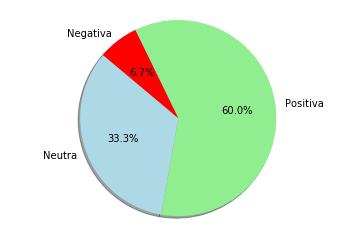

In [0]:
import matplotlib.pyplot as plt

# Data to plot
freq = predDf['sentiment'].value_counts()
labels = predDf['sentiment'].unique()
sizes = [freq[l] for l in labels]
color = {'Positiva': 'lightgreen', 'Neutra': 'lightblue', 'Negativa': 'red'}
colors = [color[l] for l in labels]

# Plot
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()